# E Cigarette Smoke Free Indoor Air Clustering

## ML Assignment 5: Logistic Regression

### Course code : CMPE-257
Group name : Spartans <br/>
Members :<br/>
                   * SUDHA AMARNATH<br/>
                   * MUKESH RANJAN SAHAY<br/>
                   * THIRUMALAI NAMBI DOSS<br/>
                   * MUTHU KUMAR SUKUMARAN<br/>


#### 1.  Data Story 

The STATE System houses current and historical state-level legislative data on tobacco use prevention and control policies. Data are reported on a quarterly basis. Data include information related to state legislation on smokefree indoor air in areas such as: Bars, Commercial Day Care Centers, Government Multi-Unit Housing, Government Worksites, Home-Based Day Care Centers, Hotels and Motels, Personal Vehicles, Private Multi-Unit Housing, Private Worksites, Restaurants, Bingo Halls, Casinos, Enclosed Arenas, Grocery Stores, Hospitals, Hospital Campuses, Malls, Mental Health Outpatient and Residential Facilities, Prisons, Public Transportation, Racetrack Casinos, Substance Abuse Outpatient and Residential Facilities.


As for the vaping trend analysis, we want to know what kinds of provision locations the e-cigarette trend is high for a given province. In this way, we could find where the e-cigarette smoking is banned, allowed of if there are any fines in the province. 


Following steps are done to arrive at the business conclusion.

1. Identifying your data story with your team
2. Selecting an initial strong data set to conduct all of your homeworks and term long project on.
3. Running linear regression on multiple features (one at a time).
4. Conducting data preparation on your data
5. Conducting data enrichment by adding one or more data sets to your base data set
6. Finding a latent manifold
7. Using the manifold to add features to your data set and run regression or clustering based on those new features.
8. Business Conclusion

#### Team Contribution
a. Data preparation and analysing Measure Description - MUTHU KUMAR SUKUMARAN <br/>
b. Data Enrichment, apply Logistic Regression and Visualizing Results in maps for Lung Injury - SUDHA AMARNATH <br/>
c. Plot Sigmoid function for the data set - MUKESH RANJAN SAHAY <br/>
d. Rerun Linear Regression Comparing Sigmoid function - THIRUMALAI NAMBI DOSS <br/>



#### 2. Dataset Selection 
### [Google Drive Dataset Link1](https://drive.google.com/open?id=14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V) 
### [Google Drive Dataset Link2](https://drive.google.com/open?id=1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok) 



### Importing Required Libraries

In [0]:

import random
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sklearn.cluster.k_means_
import tensorflow as tf
import seaborn as sns
import plotly.graph_objects as go

from time import time
from sklearn import mixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from scipy.spatial.distance import cdist
%matplotlib inline

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [230]:
# load the CSV file and create a new DataFrame out of it.
file1 = 'CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv'
link = 'https://drive.google.com/open?id=1i6qAx5aKxVEJXTXQ1LeOaClY_LryqSW5'
fluff, id = link.split('=')
print('File Name = ', file1)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file1)  

#file1 = '/Users/admin/Desktop/aliDatasets/CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv'
#df = pd.read_csv(file1,low_memory=False, nrows=100000)
df = pd.read_csv(file1,low_memory=False)
df = df[df['YEAR'] >= 2017] 
df = df.sample(frac=1)
df = df.head(100000).reset_index(drop=True)
print(df.shape)
origdf = df
df.head(2)



File Name =  CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv
File ID =  1i6qAx5aKxVEJXTXQ1LeOaClY_LryqSW5
(98967, 23)


,YEAR,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,Citation,ProvisionAltValue,DataType,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID
0,2018,2,MD,Maryland,Legislation - E-Cigarette - Smokefree Indoor Air,Private Worksites,OSH,Additional Requirements,Minimum Number of Employees Required,No Provision,NaN,0,Ranking,NaN,NaN,NaN,"(39.29058096400047, -76.60926011099963)",3,LEG,1042LEG,1006PWK,20GRP,685
1,2017,4,SC,South Carolina,Legislation - E-Cigarette - Smokefree Indoor Air,Private Worksites,OSH,Penalties,Penalty to Business (Type),No Provision,NaN,0,NaN,NaN,NaN,NaN,"(33.998821303000454, -81.04537120699968)",14,LEG,1042LEG,1006PWK,60GRP,696


### Preparing dataset
Replace the given LocationDesc value with the mapped equivalent, LocationID<br/>
Replace the given ProvisionGroupDesc value with the mapped equivalent, ProvisionGroupID<br/>
Replace the given ProvisionValue value with the mapped equivalent, ProvisionValueID<br/>
Replace the given MeasureDesc value with the mapped equivalent, MeasureDescID<br/>
Replace the given ProvisionDesc value with the mapped equivalent, ProvisionDescID<br/>


In [0]:
def mapLatitudeLongitude(df):
    global latMapping, lonMapping
    lat = []
    lon = []
    for row in df['GeoLocation']:
        try:
            lat.append(row.split(',')[0].strip('('))
            lon.append(row.split(',')[1].strip(')'))
        except:
            lat.append(np.NaN)
            lon.append(np.NaN)
    df['Latitude'] = lat
    df['Longitude'] = lon

    lat = df['Latitude'].unique().tolist()
    lon = df['Longitude'].unique().tolist()
    latMapping = dict( zip(lat,range(len(lat))) )
    lonMapping = dict( zip(lon,range(len(lon))) )

mapLatitudeLongitude(df)    
#print(latMapping)
#print(lonMapping)



In [0]:
def mapLocationID(df):
    global locationIndexList, locAbbrIndexList, latitudeIndexList, longitudeIndexList
    location_id = df['LocationDesc'].unique().tolist()
    mapping = dict( zip(location_id,range(len(location_id))) )
    df.replace({'location_id': mapping},inplace=True)
    LocationID = []
    for row in df['LocationDesc']:
        try:
            LocationID.append(mapping[row.strip()])
        except:
            LocationID.append(np.NaN)
    df['LocationID'] = LocationID

    locationIndexList = list(set(LocationID))
    latitudeIndexList = []
    longitudeIndexList = []
    locAbbrIndexList = []

    for i in locationIndexList:
      latitudeIndexList.append(df.loc[df['LocationID'] == i, 'Latitude'].iloc[0])
      longitudeIndexList.append(df.loc[df['LocationID'] == i, 'Longitude'].iloc[0])
      locAbbrIndexList.append(df.loc[df['LocationID'] == i, 'LocationAbbr'].iloc[0])

    latitudeIndexList = list(np.float_(latitudeIndexList))
    longitudeIndexList = list(np.float_(longitudeIndexList))

mapLocationID(df)

#print(locationIndexList)
#print(locAbbrIndexList)

#print(latitudeIndexList)
#print(longitudeIndexList)


In [0]:
def mapProvisionGroupId(df):
    provision_group_id = df['ProvisionGroupDesc'].unique().tolist()
    mapping = dict( zip(provision_group_id,range(len(provision_group_id))) )
    df.replace({'provision_group_id': mapping},inplace=True)

    ProvisionGroupID = []
    for row in df['ProvisionGroupDesc']:
        try:
            ProvisionGroupID.append(mapping[row.strip()])
        except:
            ProvisionGroupID.append(np.NaN)
    df['ProvisionGroupID'] = ProvisionGroupID
    
mapProvisionGroupId(df)

In [0]:
def mapProvisionValueId(df):
    provision_value_id = df['ProvisionValue'].unique().tolist()
    mapping = dict( zip(provision_value_id,range(len(provision_value_id))) )
    df.replace({'provision_value_id': mapping},inplace=True)

    ProvisionValueID = []
    for row in df['ProvisionValue']:
        try:
            ProvisionValueID.append(mapping[row.strip()])
        except:
            ProvisionValueID.append(np.NaN)
    df['ProvisionValueID'] = ProvisionValueID

mapProvisionValueId(df)

In [0]:
def mapMeasureDescId(df):
    measure_desc_id = df['MeasureDesc'].unique().tolist()
    mapping = dict( zip(measure_desc_id,range(len(measure_desc_id))) )
    df.replace({'measure_desc_id': mapping},inplace=True)

    MeasureDescID = []
    for row in df['MeasureDesc']:
        try:
            MeasureDescID.append(mapping[row.strip()])
        except:
            MeasureDescID.append(np.NaN)
    df['MeasureDescID'] = MeasureDescID

mapMeasureDescId(df)

In [0]:
def mapProvisionDescId(df):

    provision_desc_id = df['ProvisionDesc'].unique().tolist()
    mapping = dict( zip(provision_desc_id,range(len(provision_desc_id))) )
    df.replace({'provision_desc_id': mapping},inplace=True)

    ProvisionDescID = []
    for row in df['ProvisionDesc']:
        try:
            ProvisionDescID.append(mapping[row.strip()])
        except:
            ProvisionDescID.append(np.NaN)
    df['ProvisionDescID'] = ProvisionDescID

mapProvisionDescId(df)

### Remove a row or a column from  dataframe which has a NaN or no values in it.


In [237]:
#ProvisionID is ProvisionDesc
#LocationID is LocationDesc
#ProvisionGroupID is ProvisionGroupDesc
#ProvisionValueID is ProvisionValue
#ProvisionDescID is ProvisionDesc
#MeasureDescID is MeasureDesc

df.dropna(subset = ['ProvisionID', 'LocationID', 'ProvisionGroupID', 'ProvisionValueID', 'MeasureDescID','ProvisionDescID'], inplace = True)
print(df.shape)
df.head(2)

(98967, 29)


,YEAR,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,Citation,ProvisionAltValue,DataType,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID,Latitude,Longitude,LocationID,ProvisionValueID,MeasureDescID,ProvisionDescID
0,2018,2,MD,Maryland,Legislation - E-Cigarette - Smokefree Indoor Air,Private Worksites,OSH,Additional Requirements,Minimum Number of Employees Required,No Provision,NaN,0,Ranking,NaN,NaN,NaN,"(39.29058096400047, -76.60926011099963)",3,LEG,1042LEG,1006PWK,0,685,39.29058096400047,-76.60926011099963,0,0,0,0
1,2017,4,SC,South Carolina,Legislation - E-Cigarette - Smokefree Indoor Air,Private Worksites,OSH,Penalties,Penalty to Business (Type),No Provision,NaN,0,NaN,NaN,NaN,NaN,"(33.998821303000454, -81.04537120699968)",14,LEG,1042LEG,1006PWK,1,696,33.998821303000454,-81.04537120699968,1,0,0,1


### Set cluster data - Create a cluster data frame cdf having columns `LocationID` and `MeasureDescID`


In [238]:

df_col_value_1 = 'LocationID'
df_col_value_2 = 'MeasureDescID'
# create the cluster data frame cdf
cdf = df.loc[:,[df_col_value_1, df_col_value_2]]
cdf.head()



,LocationID,MeasureDescID
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


In [0]:
def getRowIndex(ndf, ll):
  ndflocList = ndf['LocationID'].tolist()
  return ndflocList.index(ll)


### Bar graph showing the States Location Distribution

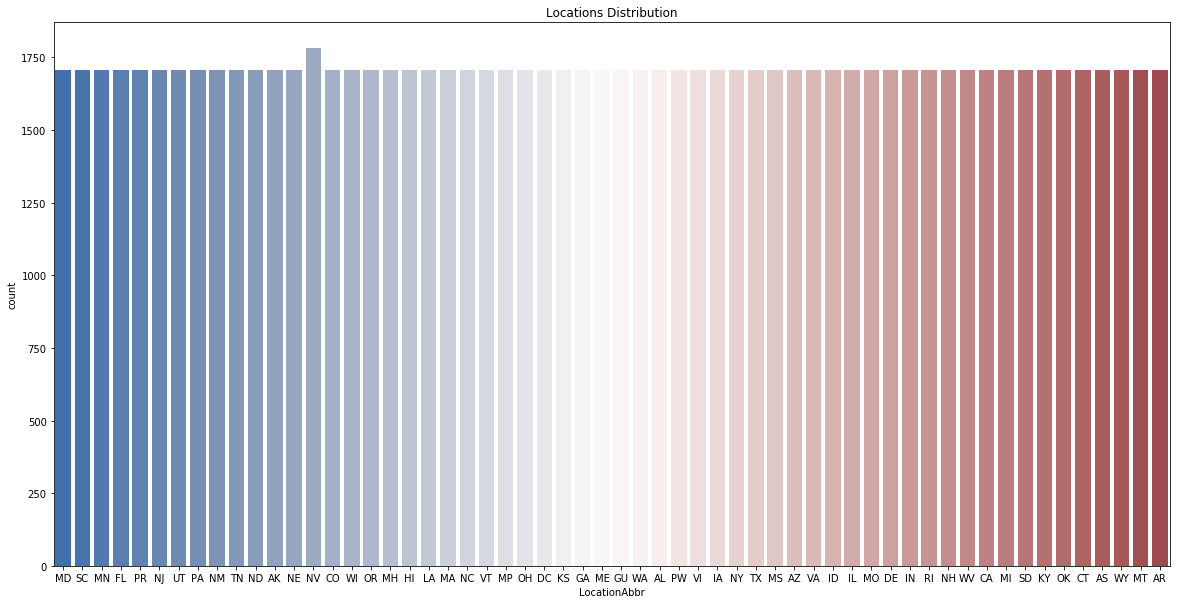

In [240]:
f, ax = plt.subplots(1,1, figsize = (20, 10))
sns.countplot(x=df['LocationAbbr'], ax = ax, palette="vlag")
ax.set_title('Locations Distribution')
plt.show()


### Bar graph showing the number of occurance of the Measure Description Distributions.


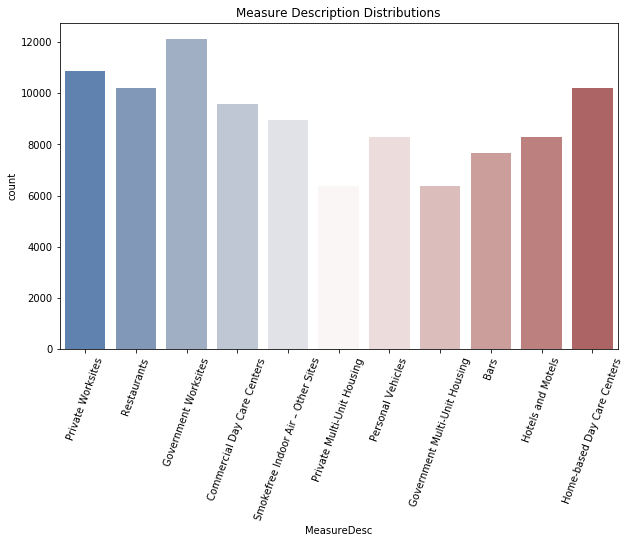

In [241]:
f, ax = plt.subplots(1,1, figsize = (10, 6))
sns.countplot(x=df['MeasureDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('Measure Description Distributions')
plt.show()

### Bar graph showing the number of occurance of the Provision Description Distributions.


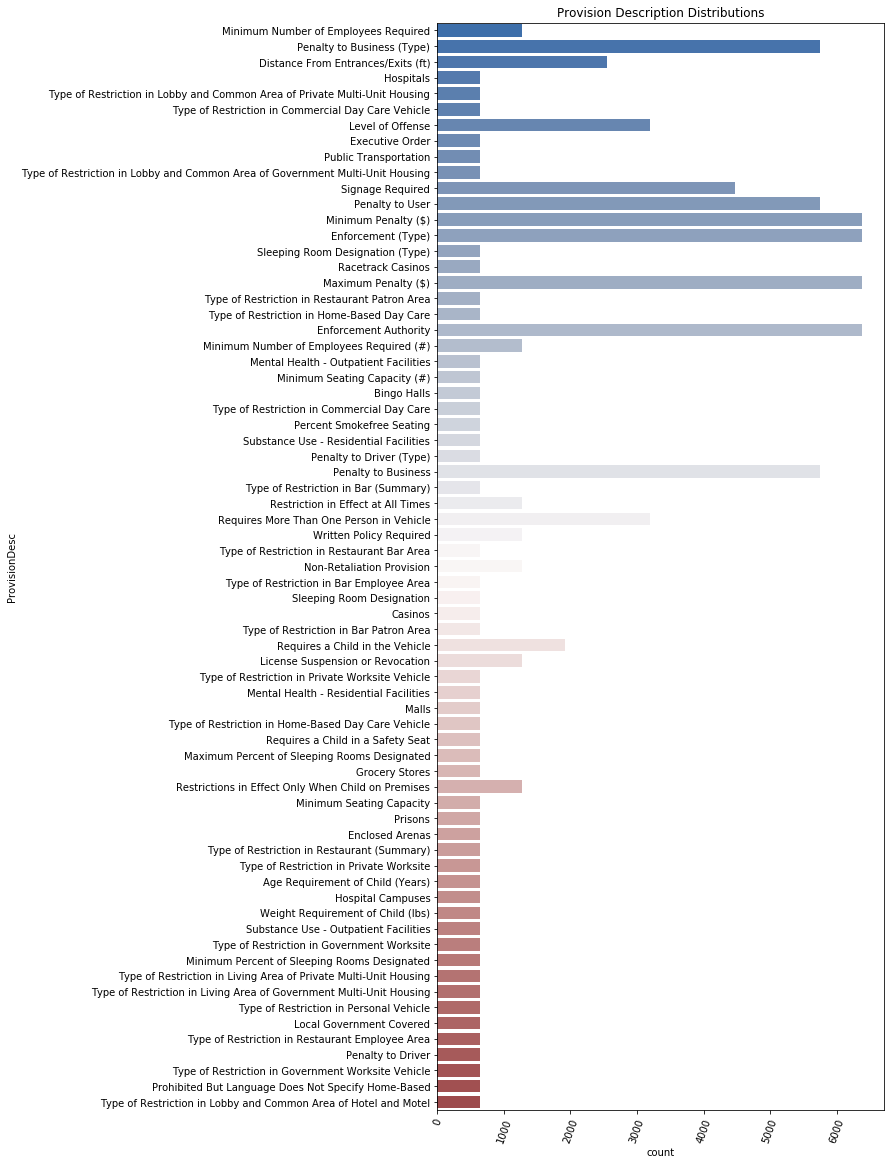

In [242]:
f, ax = plt.subplots(1,1, figsize = (8, 20))
sns.countplot(y=df['ProvisionDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('Provision Description Distributions')
plt.show()

### Linear Regression Plot before Data Enrichment - (LocationID, ProvisionGroupID)

3.428182293596649e-09


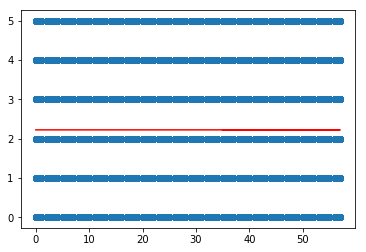

In [243]:
x = df.loc[:, ['LocationID']]
y = df.loc[:, ['ProvisionGroupID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression Plot before Data Enrichment - (LocationID, MeasureDescID)

2.237830698526011e-09


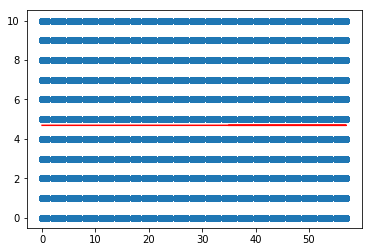

In [244]:
x = df.loc[:, ['LocationID']]
y = df.loc[:, ['MeasureDescID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression Plot before Data Enrichment - (ProvisionGroupID, MeasureDescID)

0.0031535635058365097


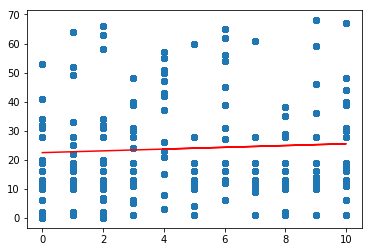

In [245]:
y = df.loc[:, ['ProvisionDescID']]
x = df.loc[:, ['MeasureDescID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Data Enrichment - Pre Latent manifold

In [246]:

rdf = df.groupby(["LocationID", "MeasureDesc"]).size().reset_index(name="Restricted")

indexNames = rdf[(rdf['MeasureDesc'] != "Bars") & (rdf['MeasureDesc'] != "Restaurants") & (rdf['MeasureDesc'] != "Government Worksites") & (rdf['MeasureDesc'] != "Private Worksites")].index
rdf.drop(indexNames , inplace=True)
print(rdf.shape)
print(rdf.head())

bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites']

ndf = pd.DataFrame(rdf.LocationID.unique(), columns =['LocationID'])
for bl in bannedList:
  ndf[bl] = 0

locList = ndf.LocationID.unique().tolist()

for ll in locList:
    for bl in bannedList:
        try:
          val = rdf.loc[(rdf['LocationID'] == ll) & (rdf['MeasureDesc'] == bl), 'Restricted'].values[0]
          rowindex = getRowIndex(ndf, ll)
          if rowindex != -1:
            ndf.set_value(rowindex, bl, val)
          else:
            print(False, ndf.at[ll, 'LocationID'])
        except:
          ndf.set_value(rowindex, bl, 0)

ndf = ndf.fillna(0)
ndf.head()


(232, 3)
    LocationID           MeasureDesc  Restricted
0            0                  Bars         132
3            0  Government Worksites         209
8            0     Private Worksites         187
9            0           Restaurants         176
11           1                  Bars         132


,LocationID,Bars,Restaurants,Government Worksites,Private Worksites
0,0,132,176,209,187
1,1,132,176,209,187
2,2,132,176,209,187
3,3,132,176,209,187
4,4,132,176,209,187


### Enrichement with new data set for only Bars, Restaurants and Worksites

In [247]:
for bl in bannedList:        
  ndf[bl] = pd.to_numeric(ndf[bl], errors='ignore')          

ndf['Restricted'] = ndf['Bars'] + ndf['Restaurants'] + ndf['Government Worksites'] + ndf['Private Worksites']

ndf['Latitude'] = ''
ndf['Longitude'] = ''


loc = ndf['LocationID'].unique().tolist()
locMapping = dict( zip(loc,range(len(loc))) )

#print(locationIndexList)
#print(latitudeIndexList)
#print(longitudeIndexList)
#print(locAbbrIndexList)


for ll in locList:
    locidxval = locationIndexList[ll]
    locidxvalndf = locList.index(ll)
    latval = latitudeIndexList[locidxval]
    lonval = longitudeIndexList[locidxval]
    abbval = locAbbrIndexList[locidxval]
    ndf.set_value(locidxvalndf, 'Latitude', latval )
    ndf.set_value(locidxvalndf, 'Longitude', lonval )
    ndf.set_value(locidxvalndf, 'LocationAbbr', abbval )
    
ndf.head(100)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Restricted,Latitude,Longitude,LocationAbbr
0,0,132,176,209,187,704,39.2906,-76.6093,MD
1,1,132,176,209,187,704,33.9988,-81.0454,SC
2,2,132,176,209,187,704,46.3556,-94.7942,MN
3,3,132,176,209,187,704,28.932,-81.929,FL
4,4,132,176,209,187,704,18.2208,-66.5901,PR
5,5,132,176,209,187,704,40.1306,-74.2737,NJ
6,6,132,176,209,187,704,39.3607,-111.587,UT
7,7,132,176,209,187,704,40.7937,-77.8607,PA
8,8,132,176,209,187,704,34.5209,-106.241,NM
9,9,132,176,209,187,704,35.6809,-85.7745,TN


### Data Enrichement - to merge Two data sets

In [248]:

file2 = 'CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Campus.csv'
link = 'https://drive.google.com/open?id=1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok'
fluff, id = link.split('=')
print('File Name = ', file2)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file2)  

sf = pd.read_csv(file2,low_memory=False)
sf = sf[sf['YEAR'] >= 2017] 
sf = sf.sample(frac=1)
sf = sf.head(100000).reset_index(drop=True)
print(sf.corrwith(origdf, axis = 1))
df = pd.concat([origdf, sf])

print(sf.shape)
print(df.shape)

# Create indices for df
mapLatitudeLongitude(df)    
mapLocationID(df)
mapProvisionGroupId(df)
mapProvisionValueId(df)
mapMeasureDescId(df)
mapProvisionDescId(df)

df.head(5)


File Name =  CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Campus.csv
File ID =  1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok
0        0.998309
1        0.996637
2        0.997822
3        0.999720
4        0.999246
5        0.997479
6        0.998503
7        0.999940
8        0.998859
9        0.999316
10       0.997063
11       0.999809
12       0.993198
13       0.999829
14       0.991294
15       0.999515
16       0.998516
17       0.999843
18       0.999315
19       0.996643
20       0.999640
21       0.999583
22       0.997947
23       0.998538
24       0.999109
25       0.999639
26       0.998938
27       0.996644
28       0.998878
29       0.543828
           ...   
98937         NaN
98938         NaN
98939         NaN
98940         NaN
98941         NaN
98942         NaN
98943         NaN
98944         NaN
98945         NaN
98946         NaN
98947         NaN
98948         NaN
98949         NaN
98950         NaN
98951         NaN
98952         NaN
98953         NaN
98954         

,Citation,Comments,DataSource,DataType,DisplayOrder,Effective_Date,Enacted_Date,GeoLocation,Latitude,LocationAbbr,LocationDesc,LocationID,Longitude,MeasureDesc,MeasureDescID,MeasureId,ProvisionAltValue,ProvisionDesc,ProvisionDescID,ProvisionGroupDesc,ProvisionGroupID,ProvisionID,ProvisionValue,ProvisionValueID,Quarter,TopicDesc,TopicId,TopicTypeId,YEAR
0,NaN,NaN,OSH,Ranking,3,NaN,NaN,"(39.29058096400047, -76.60926011099963)",39.29058096400047,MD,Maryland,0,-76.60926011099963,Private Worksites,0,1006PWK,0,Minimum Number of Employees Required,0,Additional Requirements,0,685,No Provision,0,2,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018
1,NaN,NaN,OSH,NaN,14,NaN,NaN,"(33.998821303000454, -81.04537120699968)",33.998821303000454,SC,South Carolina,1,-81.04537120699968,Private Worksites,0,1006PWK,0,Penalty to Business (Type),1,Penalties,1,696,No Provision,0,4,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2017
2,NaN,NaN,OSH,NaN,5,NaN,NaN,"(46.35564873600049, -94.79420050299967)",46.35564873600049,MN,Minnesota,2,-94.79420050299967,Restaurants,1,1007RES,0,Distance From Entrances/Exits (ft),2,Restriction Areas,2,704,No Provision,0,2,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018
3,NaN,NaN,OSH,Ranking,5,NaN,NaN,"(28.932040377000476, -81.92896053899966)",28.932040377000476,FL,Florida,3,-81.92896053899966,Government Worksites,2,1003GWK,0,Minimum Number of Employees Required,0,Additional Requirements,0,624,No Provision,0,3,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2018
4,24 L.P.R.A. § 898,NaN,OSH,NaN,11,4/11/2011,4/11/2011,"(18.220833, -66.590149)",18.220833,PR,Puerto Rico,4,-66.590149,Commercial Day Care Centers,3,1008CDC,0,Penalty to Business (Type),1,Penalties,1,605,Fine,1,2,Legislation - E-Cigarette - Smokefree Indoor Air,1042LEG,LEG,2019


### Correlation map for the data frame columns

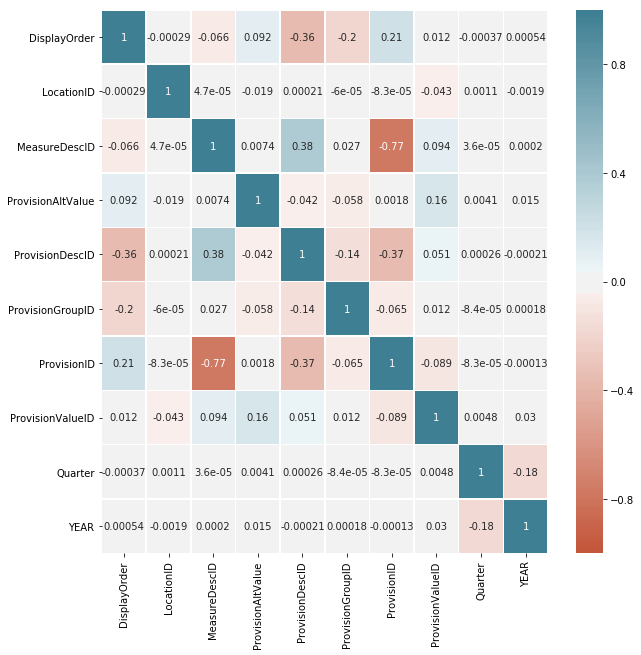

In [249]:

Cor = df[df.columns] 
#Calculate the correlation of the above variables
cor = Cor.corr() 
#Plot the correlation as heat map
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cor,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200), annot=True,linewidths=.5, ax=ax)

### Post Data Enrichment: Bar Graph showing Messure Description (It includes Public and Private Schools now)

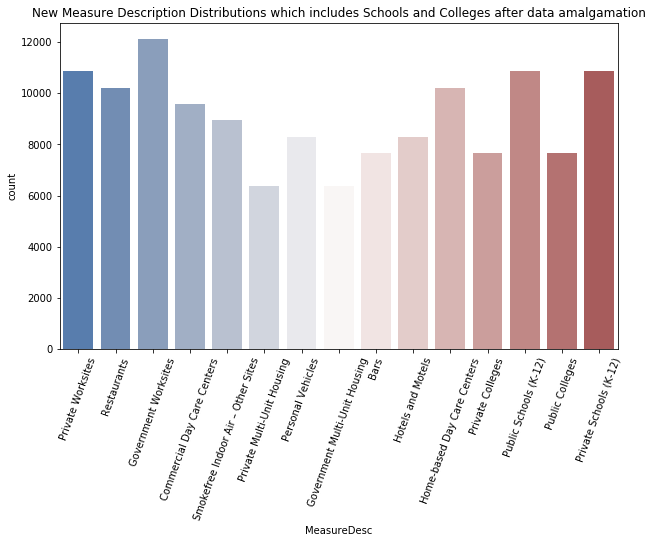

In [250]:
f, ax = plt.subplots(1,1, figsize = (10, 6))
sns.countplot(x=df['MeasureDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('New Measure Description Distributions which includes Schools and Colleges after data amalgamation')
plt.show()

### Data Enrichment - Post Latent manifold (It includes Public and Private Schools now)

In [251]:

rdf = df.groupby(["LocationID", "MeasureDesc"]).size().reset_index(name="Restricted")

indexNames = rdf[(rdf['MeasureDesc'] != "Bars") & \
                 (rdf['MeasureDesc'] != "Restaurants") & \
                 (rdf['MeasureDesc'] != "Government Worksites") & \
                 (rdf['MeasureDesc'] != "Private Worksites") & \
                 (rdf['MeasureDesc'] != "Public Colleges") & \
                 (rdf['MeasureDesc'] != "Private Colleges") & \
                 (rdf['MeasureDesc'] != "Private Schools (K-12)") & \
                 (rdf['MeasureDesc'] != "Public Schools (K-12)")].index
rdf.drop(indexNames , inplace=True)
print(rdf.shape)
print(rdf.head(8))

bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites', \
              'Public Colleges', 'Public Schools (K-12)', 'Private Colleges', 'Private Schools (K-12)']

ndf = pd.DataFrame(rdf.LocationID.unique(), columns =['LocationID'])
for bl in bannedList:
  ndf[bl] = 0

locList = ndf.LocationID.unique().tolist()

for ll in locList:
    for bl in bannedList:
        try:
          val = rdf.loc[(rdf['LocationID'] == ll) & (rdf['MeasureDesc'] == bl), 'Restricted'].values[0]
          rowindex = getRowIndex(ndf, ll)
          if rowindex != -1:
            ndf.set_value(rowindex, bl, val)
          else:
            print(False, ndf.at[ll, 'LocationID'])
        except:
          ndf.set_value(rowindex, bl, 0)

ndf = ndf.fillna(0)

print('\nNew NDF data structure includes all Public and Private Schools along with Bars, Restaurants, Worksites\n')
ndf.head()

(464, 3)
    LocationID             MeasureDesc  Restricted
0            0                    Bars         132
3            0    Government Worksites         209
7            0        Private Colleges         132
9            0  Private Schools (K-12)         187
10           0       Private Worksites         187
11           0         Public Colleges         132
12           0   Public Schools (K-12)         187
13           0             Restaurants         176

New NDF data structure includes all Public and Private Schools along with Bars, Restaurants, Worksites



,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12)
0,0,132,176,209,187,132,187,132,187
1,1,132,176,209,187,132,187,132,187
2,2,132,176,209,187,132,187,132,187
3,3,132,176,209,187,132,187,132,187
4,4,132,176,209,187,132,187,132,187


### Total Restricted count of Bars, Restaurants, Worksites and Scools are calculated - post enrichment

In [252]:
for bl in bannedList:        
  ndf[bl] = pd.to_numeric(ndf[bl], errors='ignore')          

bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites', \
              'Public Colleges', 'Public Schools (K-12)', 'Private Colleges', 'Private Schools (K-12)']

ndf['RestrictedAdults'] = ndf['Bars'] + ndf['Restaurants'] + ndf['Government Worksites'] + ndf['Private Worksites']
ndf['RestrictedYouth'] = ndf['Public Colleges'] + ndf['Public Schools (K-12)'] + ndf['Private Colleges'] + ndf['Private Schools (K-12)']

ndf['RestrictedTotal'] = ndf['RestrictedAdults'] + ndf['RestrictedYouth']

ndf['Latitude'] = ''
ndf['Longitude'] = ''

loc = ndf['LocationID'].unique().tolist()
locMapping = dict( zip(loc,range(len(loc))) )

for ll in locList:
    locidxval = locationIndexList[ll]
    locidxvalndf = locList.index(ll)
    latval = latitudeIndexList[locidxval]
    lonval = longitudeIndexList[locidxval]
    abbval = locAbbrIndexList[locidxval]
    ndf.set_value(locidxvalndf, 'Latitude', latval )
    ndf.set_value(locidxvalndf, 'Longitude', lonval )
    ndf.set_value(locidxvalndf, 'LocationAbbr', abbval )
    
ndf.head(5)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12),RestrictedAdults,RestrictedYouth,RestrictedTotal,Latitude,Longitude,LocationAbbr
0,0,132,176,209,187,132,187,132,187,704,638,1342,39.2906,-76.6093,MD
1,1,132,176,209,187,132,187,132,187,704,638,1342,33.9988,-81.0454,SC
2,2,132,176,209,187,132,187,132,187,704,638,1342,46.3556,-94.7942,MN
3,3,132,176,209,187,132,187,132,187,704,638,1342,28.932,-81.929,FL
4,4,132,176,209,187,132,187,132,187,704,638,1342,18.2208,-66.5901,PR


### Linear Regression post data enrichment (manifold) - For (LocationID, RestrictedAdults)

0.015039829725963516


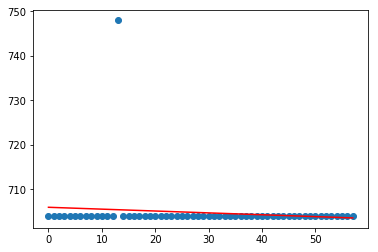

In [253]:
x = ndf.loc[:, ['LocationID']]
y = ndf.loc[:, ['RestrictedAdults']]
reg = LinearRegression().fit(x, y)
print(reg.score(x,y))
predict = reg.predict(x)
plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression post data enrichment (manifold) - For (LocationID, RestrictedYouth)

0.007629327133501063


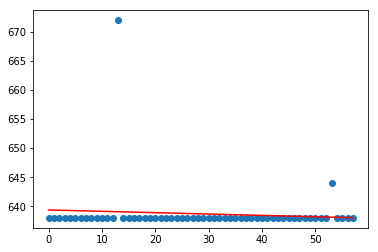

In [254]:
x = ndf.loc[:, ['LocationID']]
y = ndf.loc[:, ['RestrictedYouth']]
reg = LinearRegression().fit(x, y)
print(reg.score(x,y))
predict = reg.predict(x)
plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Linear Regression post data enrichment (manifold) - For (ProvisionDescID, MeasureDescID)

Citation              object
Comments              object
DataSource            object
DataType              object
DisplayOrder           int64
Effective_Date        object
Enacted_Date          object
GeoLocation           object
Latitude              object
LocationAbbr          object
LocationDesc          object
LocationID             int64
Longitude             object
MeasureDesc           object
MeasureDescID          int64
MeasureId             object
ProvisionAltValue      int64
ProvisionDesc         object
ProvisionDescID        int64
ProvisionGroupDesc    object
ProvisionGroupID       int64
ProvisionID            int64
ProvisionValue        object
ProvisionValueID       int64
Quarter                int64
TopicDesc             object
TopicId               object
TopicTypeId           object
YEAR                   int64
dtype: object
0.14372678006710715


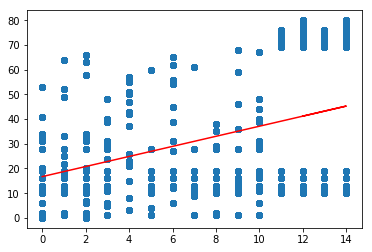

In [255]:
print(df.dtypes)

y = df.loc[:, ['ProvisionDescID']]
x = df.loc[:, ['MeasureDescID']]

reg = LinearRegression().fit(x, y)
print(reg.score(x,y))

predict = reg.predict(x)

plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Comprehensive = Total Restricted in worksites, restaurants, bars and schools as of Q3 2019 Interactive Map Plot

In [256]:
for col in ndf.columns:
    ndf[col] = ndf[col].astype(str)

ndf['text'] = ndf['LocationAbbr'] + '<br>' + \
    'Bars: ' + ndf['Bars'] + '<br>' + \
    'Restaurants: ' + ndf['Restaurants'] + '<br>' + \
    'Government Worksites: ' + ndf['Government Worksites'] + '<br>' + \
    'Private Worksites: ' + ndf['Private Worksites'] + '<br>' + \
    'Private Schools (K-12): ' + ndf['Private Schools (K-12)'] + '<br>' + \
    'Public Schools (K-12): ' + ndf['Public Schools (K-12)'] + '<br>' + \
    'Private Colleges: ' + ndf['Private Colleges'] + '<br>' + \
    'Public Colleges: ' + ndf['Public Colleges'] + '<br>'

fig = go.Figure(data=go.Choropleth(
    locations=ndf['LocationAbbr'],
    z=ndf['RestrictedTotal'].astype(float),
    locationmode='USA-states',
    colorscale='Earth',
    zmin = min(ndf['RestrictedTotal'].astype(float)) - 0,
    zmax = max(ndf['RestrictedTotal'].astype(float)),
    autocolorscale=False,
    text=ndf['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="RestrictedTotal"
))

fig.update_layout(
    title_text='Comprehensive = Restricted in worksites, restaurants, bars and schools as of Q3 2019.<br>(Hover for breakdown)',
    autosize=False,
    width=1200,
    height=800,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

### Map Analysis, New develpments and Insights

An interactive map as of Q3 2019 is visualized using Matlab Plotly Choropleth displaying USA States. Total Restricted count that is sum of Measure Description Parameters of Bars, Restaurants, Government Worksites and Private Worksites are calculated per state. This data is displayed when hovering over each state on the USA Map. For the data selected with 175K rows, following insights can be noticed.

1. All states have restrictions to some extent.
2. State Nevada tops the list. 
3. Almost all the remaining have nearly same usage and restrictions from both the data sets. 

### Data Enrichment, Linear Regression, Latent Manifold and Logistic Regression
Initially we plotted the Linear regression for our first data set which has only content about the smokefree indoor air restrictions for Measure Descriptions in Bars, Restaurants and Worksites. We have plotted for different columns (LocationID, ProvisionGroupDescID), (LocationID, MeasureDescID), (ProvisionDescID, MeasureDescID). Later we found that we could also include smokefree restrictions in campus for Youth. We enriched the two data sets and selectively created new colums to finally calculate the Total Restrictions, Restrictions for Adults and Youth Separately. Then we again re ran the Linear regressions for the data.

### Business Conclusion

* How does this improve the interpretability of your model?
    - In our use case, Linear Regression is used to predict Measure Description feature against our Provision Descrition ID and Location based Description ID. We have plotted the visualization of counts for smokefree indoor air for restaurants, bars, and worksites for adults using Location Based Maps with the first data set. Later we found that data about the Youth in Colleges are missing. We have used latent manifold to enrich the data selectively using different columns and totalling the restricted counts for both adults and youth.
* How does it add value to your business case?
    - In our usecase, we have again visualized the complete restricted counts for smokefree indoor air for both adults and youth using latent manifold. Then post enrichment we have done linear regression for Provision ID, Measure Descrition and Location ID based e-cigarette smokefree indoor air and campus 

In [257]:
'''
file2 = 'CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Campus.csv'
link = 'https://drive.google.com/open?id=1SFMMrd4fL4J-l_bTiDtBUzMVDHqcdfok'
fluff, id = link.split('=')
print('File Name = ', file2)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file2)  

sf = pd.read_csv(file2,low_memory=False)
sf = sf[sf['YEAR'] >= 2017] 
sf = sf.sample(frac=1)
sf = sf.head(100000).reset_index(drop=True)
#print(sf.corrwith(origdf, axis = 1))
df = pd.concat([origdf, sf])

print(sf.shape)
print(df.shape)

# Create indices for df
mapLatitudeLongitude(df)    
mapLocationID(df)
mapProvisionGroupId(df)
mapProvisionValueId(df)
mapMeasureDescId(df)
mapProvisionDescId(df)

df.head(2)
'''

orig = ndf
ndf.head(2)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12),RestrictedAdults,RestrictedYouth,RestrictedTotal,Latitude,Longitude,LocationAbbr,text
0,0,132,176,209,187,132,187,132,187,704,638,1342,39.29058096400047,-76.60926011099963,MD,MD<br>Bars: 132<br>Restaurants: 176<br>Governm...
1,1,132,176,209,187,132,187,132,187,704,638,1342,33.998821303000454,-81.04537120699968,SC,SC<br>Bars: 132<br>Restaurants: 176<br>Governm...


In [258]:
ndf = orig
ndf.head(2)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12),RestrictedAdults,RestrictedYouth,RestrictedTotal,Latitude,Longitude,LocationAbbr,text
0,0,132,176,209,187,132,187,132,187,704,638,1342,39.29058096400047,-76.60926011099963,MD,MD<br>Bars: 132<br>Restaurants: 176<br>Governm...
1,1,132,176,209,187,132,187,132,187,704,638,1342,33.998821303000454,-81.04537120699968,SC,SC<br>Bars: 132<br>Restaurants: 176<br>Governm...


##Scrape the LungInjuryCount from URL for fields Frequency and Rating append lungInjuryCount column to the merged dataset.

In [259]:
import json
import urllib
import urllib.request, json 
with urllib.request.urlopen("https://www.cdc.gov/tobacco/basic_information/e-cigarettes/assets/lung-injury-cases-map.json") as url:
    data = json.loads(url.read().decode())
global lungInjuryCountStatesList
lungInjuryCountStatesList = data['data']

print(len(lungInjuryCountStatesList))

i = 1
for s in lungInjuryCountStatesList:
  i = i + 1
  if s['STATE'] is not None:
    print(s['STATE'],",",  s['Frequency'],",", s['Rating'])


60
AL , 1-9 cases , 4
AK , 0 cases , 0
AS , 0 cases , None
AZ , 1-9 cases , 7
AR , 10-49 cases , 8
CA , 100-149 cases , 102
CO , 1-9 cases , 9
CT , 10-49 cases , 21
DE , 10-49 cases , 11
DC , 1-9 cases , 0
FL , 50-99 cases , 39
GA , 10-49 cases , 9
GU , 0 cases , None
HI , 1-9 cases , 1
ID , 1-9 cases , 7
IL , 100-149 cases , 96
IN , 50-99 cases , 57
IA , 10-49 cases , 23
KS , 10-49 cases , 13
KY , 1-9 cases , 4
LA , 10-49 cases , 18
ME , 1-9 cases , 5
MH , 0 cases , None
MD , 10-49 cases , 23
MA , 10-49 cases , 10
MI , 10-49 cases , 21
FM , 0 cases , None
MN , 50-99 cases , 55
MS , 1-9 cases , 5
MO , 10-49 cases , 20
MT , 1-9 cases , 2
NE , 10-49 cases , 11
NV , 1-9 cases , 4
NH , 1-9 cases , 0
NJ , 10-49 cases , 9
NM , 10-49 cases , 14
NY , 50-99 cases , 40
NC , 10-49 cases , 42
ND , 1-9 cases , 7
MP , 0 cases , None
OH , 10-49 cases , 22
OK , 1-9 cases , 4
OR , 1-9 cases , 8
PW , 0 cases , None
PA , 50-99 cases , 21
PR , 0 cases , None
RI , 1-9 cases , 2
SC , 10-49 cases , 12
SD , 1

##Append LungInjuryCasesAbove50 column to the dataset for Train/Test split

In [0]:
def getLungInjuryCountInStates(state):
  for s in lungInjuryCountStatesList:
    if s['STATE'] == state and s['Rating'] is not None:
      return s['Rating']
  return 0

In [261]:
for ll in locList:
    locidxval = locationIndexList[ll]
    locidxvalndf = locList.index(ll)
    latval = latitudeIndexList[locidxval]
    lonval = longitudeIndexList[locidxval]
    abbval = locAbbrIndexList[locidxval]
    injurycount = getLungInjuryCountInStates(abbval)
    ndf.set_value(locidxvalndf, 'LungInjuryCount', injurycount)

ndf.LungInjuryCount = ndf.LungInjuryCount.astype(int)
ndf['LungInjuryCasesAbove50'] = np.where(ndf['LungInjuryCount'] >= 50, 1, 0)

#del ndf['LungInjuryCount']
ndf.head(100)

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Public Colleges,Public Schools (K-12),Private Colleges,Private Schools (K-12),RestrictedAdults,RestrictedYouth,RestrictedTotal,Latitude,Longitude,LocationAbbr,text,LungInjuryCount,LungInjuryCasesAbove50
0,0,132,176,209,187,132,187,132,187,704,638,1342,39.29058096400047,-76.60926011099963,MD,MD<br>Bars: 132<br>Restaurants: 176<br>Governm...,23,0
1,1,132,176,209,187,132,187,132,187,704,638,1342,33.998821303000454,-81.04537120699968,SC,SC<br>Bars: 132<br>Restaurants: 176<br>Governm...,12,0
2,2,132,176,209,187,132,187,132,187,704,638,1342,46.35564873600049,-94.79420050299967,MN,MN<br>Bars: 132<br>Restaurants: 176<br>Governm...,55,1
3,3,132,176,209,187,132,187,132,187,704,638,1342,28.932040377000476,-81.92896053899966,FL,FL<br>Bars: 132<br>Restaurants: 176<br>Governm...,39,0
4,4,132,176,209,187,132,187,132,187,704,638,1342,18.220833,-66.590149,PR,PR<br>Bars: 132<br>Restaurants: 176<br>Governm...,0,0
5,5,132,176,209,187,132,187,132,187,704,638,1342,40.13057004800049,-74.27369128799967,NJ,NJ<br>Bars: 132<br>Restaurants: 176<br>Governm...,9,0
6,6,132,176,209,187,132,187,132,187,704,638,1342,39.360700171000474,-111.58713063499971,UT,UT<br>Bars: 132<br>Restaurants: 176<br>Governm...,72,1
7,7,132,176,209,187,132,187,132,187,704,638,1342,40.79373015200048,-77.86070029399963,PA,PA<br>Bars: 132<br>Restaurants: 176<br>Governm...,21,0
8,8,132,176,209,187,132,187,132,187,704,638,1342,34.52088095200048,-106.24058098499967,NM,NM<br>Bars: 132<br>Restaurants: 176<br>Governm...,14,0
9,9,132,176,209,187,132,187,132,187,704,638,1342,35.68094058000048,-85.77449091399967,TN,TN<br>Bars: 132<br>Restaurants: 176<br>Governm...,38,0


## Splitting Data into Training and Test Sets

In [262]:
df_final = ndf.loc[:,['LungInjuryCount', 'LungInjuryCasesAbove50']]
df_final.head(20)

df_final = df_final.convert_objects(convert_numeric=True)

df_final.dtypes


LungInjuryCount           int64
LungInjuryCasesAbove50    int64
dtype: object

In [263]:
dfLungInjuryState = ndf[['LungInjuryCount','LocationAbbr']]
dfLungInjuryState.head(100)

,LungInjuryCount,LocationAbbr
0,23,MD
1,12,SC
2,55,MN
3,39,FL
4,0,PR
5,9,NJ
6,72,UT
7,21,PA
8,14,NM
9,38,TN


In [0]:
features = df_final.loc[:, df_final.columns != 'LungInjuryCount']
target = df_final.loc[:, ['LungInjuryCount']]

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import train_test_split

# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [266]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(43, 1)
(43, 1)
(15, 1)
(15, 1)


# Logistic Regression Classifier 

In [267]:
# Import the model
from sklearn.linear_model import LogisticRegression


# Make an instance of the Model
clf = LogisticRegression()

# Train the model on the data 
clf.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [268]:
# import the accuracy metrics 
from sklearn.metrics import accuracy_score

# predict the value of restaurant rating 
y_pred = clf.predict(X_test)

# ratio of correctly predicted observation to the total observations
# Accuracy = TP+TN/TP+FP+FN+TN
print(accuracy_score(y_test,y_pred))

0.13333333333333333


### Classification Report and Confusion Matrix

In [269]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.13      1.00      0.24         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          57       0.00      0.00      0.00         1
          75       0.00      0.00      0.00         1
          96       0.00      0.00      0.00         1

    accuracy                           0.13        15
   macro avg       0.01      0.09      0.02        15
weighted avg       0.02      0.13      0.03        15



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Receiver Operating Characteristic (ROC) and Area Under the Circle (AUC) curve

In [270]:
from sklearn.metrics import roc_curve, auc

# ROC curve False prediction, True prediction, threshold 
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=0)
print(fpr)
print(tpr)
print(thresholds)

[0. 1.]
[0. 1.]
[1 0]


In [271]:
# AUC score
roc_auc = auc(fpr,tpr)
roc_auc

0.5

Accuracy =  0.13333333333333333


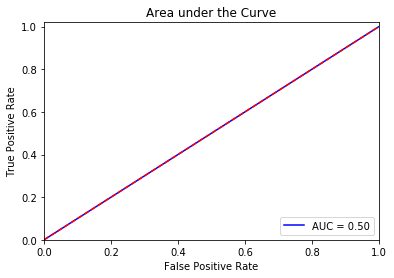

In [272]:
import matplotlib.pyplot as plt

# Graphical representaion of AUC 
print("Accuracy = ", accuracy_score(y_test, y_pred))
plt.title('Area under the Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## No. of Vaping related Lung Injury Cases Reported to CDC as of Oct 8th 2019

In [273]:
for col in ndf.columns:
    ndf[col] = ndf[col].astype(str)

ndf['injurytext'] = ndf['LocationAbbr'] 

fig = go.Figure(data=go.Choropleth(
    locations=ndf['LocationAbbr'],
    z=ndf['LungInjuryCount'].astype(float),
    locationmode='USA-states',
    colorscale='reds',
    zmin = min(ndf['LungInjuryCount'].astype(float)) - 0,
    zmax = max(ndf['LungInjuryCount'].astype(float)),
    autocolorscale=False,
    text=ndf['injurytext'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="LungInjuryCount"
))

fig.update_layout(
    title_text='No. of Vaping related Lung Injury Cases Reported to CDC as of Oct 8th 2019.<br>(Hover for breakdown)',
    autosize=False,
    width=1200,
    height=800,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

### Normalized Sigmoid Function

In [0]:
def normalized_sigmoid(center, width, x):
   s= 1/(1+np.exp(width*(x-center)))
   # normalizing sigmoid function to 0-1
   return (1- 1*(s-min(s))/(max(s)-min(s)))


### Plot Sigmoid Function

In [0]:
def plot_sigmoid(x): 
    plt.figure(figsize=(10, 8))
    plt.plot(x, normalized_sigmoid(50, .20, x), 'r', label='Lung Injuries as of Oct 8th 2019 (0,102)', linewidth=5)
    plt.grid()
    plt.title('Plot using Sigmoid Function',fontsize=18)
    # place the legend in bottom right of the graph
    plt.legend(loc='lower right')
    # write the Sigmoid formula
    plt.text(4, 0.8, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=25)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(25))
    plt.xlabel('Vaping Related Lung Injury Cases from CDC as of Oct 8th 2019 per State', fontsize=18)
    plt.ylabel('Probability more than 50 Cases', fontsize=18)
    plt.show()

In [0]:

ndf['LungInjuryCount'] = ndf['LungInjuryCount'].astype(int)
lungInjuryCountNpArray = ndf['LungInjuryCount'].to_numpy()
lungInjuryCountNpArray.sort()


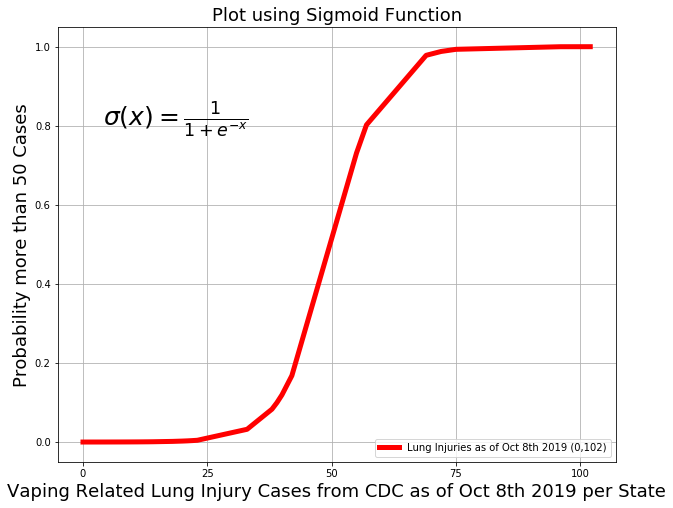

In [277]:
plot_sigmoid(lungInjuryCountNpArray)

### Applying Linear Regression to compare with the results of Lung Injury Count from Sigmoid Function Above

0.002825970154604618


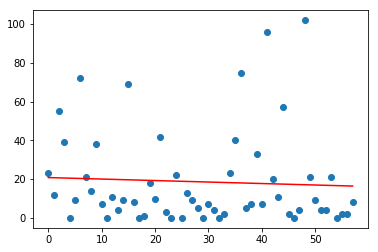

In [282]:
ndf['LocationID'] = ndf['LocationID'].astype(int)
x = ndf.loc[:, ['LocationID']]
y = df_final.loc[:, ['LungInjuryCount']]
reg = LinearRegression().fit(x, y)
print(reg.score(x,y))
predict = reg.predict(x)
plt.scatter(x, y)  
plt.plot(x,predict,color = 'red')
plt.show()

### Discuss why you chose that attribute/feature and what you are trying to learn from the classification.



Currently we plotted the Lung Injury Cases related to E Cigarette Vaping using the data set from CDC as of October 8th 2019. CDC updates this data frequently as the Outbreak is somewhat widespread all over the United States. We used urllib to get the CDC data in the json format and we did post enrichment and merged this data to the existing dataset per state. The visualization is done based on all the states in the USA state map. 

### How does this further develop the story you are telling or discovering about your data set and business problem you are trying to solve?



From the mapped states, as of Oct 8th 2019, California has around 102 lung injury cases reported and is the highest count in a state. Next states are Illinios, Texas and Utah. The Logistic regression is run and the sigmoid function is plotted for this set of data column for which the central value around 50 is chosen. To compare with Linear regression, we have taken the same column for the state IDs. 